# Обоснование выбора и методология калибровки модели Hull-White

## 1. Почему Hull-White, а не CIR?
В данной работе для моделирования стохастической динамики процентных ставок (RUONIA и SOFR) была выбрана однофакторная модель **Hull-White (Extended Vasicek)**.

Этот выбор обусловлен следующими преимуществами перед базовой моделью CIR:
1.  **Работа с околонулевыми и отрицательными ставками:**
    Модель CIR предполагает, что ставки строго положительны ($r_t > 0$). Однако в исследуемый период (2020–2021 гг.) долларовые ставки (SOFR/Fed Funds) находились около нуля, а в ряде развитых экономик уходили в отрицательную зону. Модель Hull-White, основанная на нормальном распределении, корректно работает в этих режимах.
2.  **Аналитическая трактуемость:**
    Модель позволяет получать аналитические решения для цен облигаций и опционов, что делает её стандартом де-факто для оценки деривативов на процентные ставки.

## 2. Особенности калибровки
Калибровка параметров производится методом **МНК**, аналогично подходу для модели CIR, но со следующими характерными отличиями:

* **Отсутствие взвешивания:**
    В модели CIR волатильность зависит от уровня ставки ($\sigma \sqrt{r_t}$), поэтому для применения OLS уравнение необходимо делить на $\sqrt{r_t}$.
    В модели **Hull-White** волатильность $\sigma$ является постоянной. Дисперсия ошибки не зависит от уровня ставки, поэтому деление на корень не требуется. Мы применяем прямую регрессию к дискретному уравнению.

* **Спецификация регрессии:**
    Уравнение принимает вид линейной регрессии $Y = \text{Intercept} + \text{Slope} \cdot X + \varepsilon$:
    $$r_{t+1} - r_t = \underbrace{a \mu \Delta t}_{\text{Intercept}} - \underbrace{a \Delta t}_{\text{Slope}} \cdot r_t + \varepsilon_t$$
    Где:
    * $a$ — скорость возврата к среднему (Mean Reversion Speed).
    * $\mu$ — долгосрочный средний уровень ставки.
    * $\sigma$ — абсолютная волатильность (стандартное отклонение остатков $\varepsilon$, нормированное на $\sqrt{\Delta t}$).

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [ ]:
np.random.seed(42)

def calibrate_hull_white(rates_series, dt=1/252):
    r = rates_series.values
    r_t = r[:-1]
    r_next = r[1:]

    y = r_next - r_t

    X = sm.add_constant(r_t)
    model = sm.OLS(y, X).fit()

    intercept = model.params[0] 
    slope = model.params[1]      

  
    a = -slope / dt             
    mu = intercept / (a * dt)    
    sigma = model.resid.std() / np.sqrt(dt) 

    return a, mu, sigma, model.resid



In [3]:
print("🚀 ЗАПУСК ПРОЕКТА (Модель Hull-White)...\n")

# 1.1 RUONIA (RUB)
try:
    df_rub = pd.read_csv('RC_F11_01_2010_T10_12_2021.csv', delimiter=';', decimal=',')
    df_rub['Date'] = pd.to_datetime(df_rub['DT'], dayfirst=True)
    df_rub = df_rub.set_index('Date').sort_index()
    rub_series = df_rub['ruo'] / 100
    print(f"✅ RUONIA загружена: {len(rub_series)} точек")
except Exception as e:
    print(f"❌ Ошибка с RUONIA: {e}")

# 1.2 SOFR (USD)
try:
    df_usd = pd.read_csv('SOFR.csv')
    df_usd['Date'] = pd.to_datetime(df_usd['observation_date'])
    df_usd = df_usd.set_index('Date').sort_index()
    df_usd['SOFR'] = pd.to_numeric(df_usd['SOFR'], errors='coerce')
    usd_series = df_usd['SOFR'].dropna() / 100
    print(f"✅ SOFR загружена: {len(usd_series)} точек")
except Exception as e:
    print(f"❌ Ошибка с SOFR: {e}")

# 1.3 USDRUB (FX)
try:
    df_fx = pd.read_csv('usdrub_data.csv')
    col_fx = 'RUB=X' if 'RUB=X' in df_fx.columns else df_fx.columns[1]
    df_fx['Date'] = pd.to_datetime(df_fx['Date'])
    df_fx = df_fx.set_index('Date').sort_index()
    fx_series = df_fx[col_fx]
    print(f"✅ FX загружен: {len(fx_series)} точек")
except Exception as e:
    print(f"❌ Ошибка с FX: {e}")

# Объединение
data = pd.DataFrame({
    'RUB': rub_series,
    'USD': usd_series,
    'FX': fx_series
}).dropna()['2019-01-01':'2021-12-10']

print(f"📉 Итоговый датасет: {len(data)} дней")

🚀 ЗАПУСК ПРОЕКТА (Модель Hull-White)...

--- ЭТАП 1: Загрузка данных ---
✅ RUONIA загружена: 2939 точек
✅ SOFR загружена: 924 точек
✅ FX загружен: 767 точек
📉 Итоговый датасет: 687 дней


In [ ]:
print("\n--- ЭТАП 2: Калибровка (Hull-White / OLS) ---")

a_rub, mu_rub, sigma_rub, res_rub = calibrate_hull_white(data['RUB'])

a_usd, mu_usd, sigma_usd, res_usd = calibrate_hull_white(data['USD'])

fx_vals = data['FX'].values
log_returns = np.log(fx_vals[1:] / fx_vals[:-1])
sigma_fx = np.std(log_returns) * np.sqrt(252)

# 2.4 Корреляция
residuals = pd.DataFrame({
    'dW_RUB': res_rub,       # Шум HW
    'dW_USD': res_usd,       # Шум HW
    'dW_FX': log_returns     # Шум GBM
}).dropna()
corr_matrix = residuals.corr().values

# ВЫВОД РЕЗУЛЬТАТОВ
print(f"{'ПАРАМЕТР':<10} | {'RUB (Hull-White)':<20} | {'USD (Hull-White)':<20} | {'FX (Log-Normal)':<15}")
print("-" * 75)
print(f"{'Mean (Mu)':<10} | {mu_rub:<20.4%} | {mu_usd:<20.4%} | {'-':<15}")
print(f"{'Speed (a)':<10} | {a_rub:<20.4f} | {a_usd:<20.4f} | {'-':<15}")
print(f"{'Sigma':<10} | {sigma_rub:<20.4%} | {sigma_usd:<20.4%} | {sigma_fx:<15.4%}")
print("\nМатрица корреляций:")
print(residuals.corr().round(4))




--- ЭТАП 2: Калибровка (Hull-White / OLS) ---
ПАРАМЕТР   | RUB (Hull-White)     | USD (Hull-White)     | FX (Log-Normal)
---------------------------------------------------------------------------
Mean (Mu)  | 5.8230%              | 0.6216%              | -              
Speed (a)  | 1.4343               | 3.4296               | -              
Sigma      | 2.1849%              | 2.5792%              | 13.9042%       

Матрица корреляций:
        dW_RUB  dW_USD   dW_FX
dW_RUB  1.0000  0.0446  0.0075
dW_USD  0.0446  1.0000 -0.0060
dW_FX   0.0075 -0.0060  1.0000


In [5]:
print("\n--- ЭТАП 3: Прайсинг Range Accrual (HW Engine) ---")

# Параметры сделки
Notional = 1_000_000
L_barrier = 70.0
U_barrier = 80.0
T_days = 365
dt_sim = 1/365
N_sim = 10000

# Стартовые условия
S0 = data['FX'].iloc[-1]
r_rub_0 = data['RUB'].iloc[-1]
r_usd_0 = data['USD'].iloc[-1]

# Холецкий
L_chol = np.linalg.cholesky(corr_matrix)

# Массивы траекторий
rub_path = np.zeros((N_sim, T_days + 1))
usd_path = np.zeros((N_sim, T_days + 1))
fx_path  = np.zeros((N_sim, T_days + 1))

rub_path[:, 0] = r_rub_0
usd_path[:, 0] = r_usd_0
fx_path[:, 0]  = S0

days_in_range = np.zeros(N_sim)
discount_accum = np.zeros(N_sim)




--- ЭТАП 3: Прайсинг Range Accrual (HW Engine) ---


In [9]:
for t in range(T_days):
    Z_uncorr = np.random.normal(size=(3, N_sim))
    Z = L_chol @ Z_uncorr

    r_r = rub_path[:, t]
    r_d = usd_path[:, t]
    S_t = fx_path[:, t]

    # 1. HULL-WHITE UPDATE (RUB)
    # Отличие от CIR: нет корня из r! Sigma абсолютная.
    dr_r = a_rub * (mu_rub - r_r) * dt_sim + sigma_rub * np.sqrt(dt_sim) * Z[0]
    rub_path[:, t+1] = r_r + dr_r

    # 2. HULL-WHITE UPDATE (USD)
    dr_d = a_usd * (mu_usd - r_d) * dt_sim + sigma_usd * np.sqrt(dt_sim) * Z[1]
    usd_path[:, t+1] = r_d + dr_d

    # 3. FX UPDATE (GBM с дрифтом ставок)
    drift = (r_r - r_d - 0.5 * sigma_fx**2) * dt_sim
    diff = sigma_fx * np.sqrt(dt_sim) * Z[2]
    fx_path[:, t+1] = S_t * np.exp(drift + diff)

    # Range Accrual Check
    S_next = fx_path[:, t+1]
    in_range = (S_next >= L_barrier) & (S_next <= U_barrier)
    days_in_range += in_range.astype(int)

    # Дисконтирование
    discount_accum += r_r * dt_sim



In [10]:
# Оценка
accrual_fraction = days_in_range / T_days
payoff = Notional * accrual_fraction
pv = payoff * np.exp(-discount_accum)

price = pv.mean()
std_err = pv.std() / np.sqrt(N_sim)

print("\n" + "="*40)
print(f"💰 ЦЕНА (Hull-White Model): {price:,.2f} RUB")
print(f"Процент от номинала: {(price/Notional)*100:.2f}%")
print(f"Точность: +/- {std_err:.2f}")
print("="*40)




💰 ЦЕНА (Hull-White Model): 972,731.53 RUB
Процент от номинала: 97.27%
Точность: +/- 3245.02


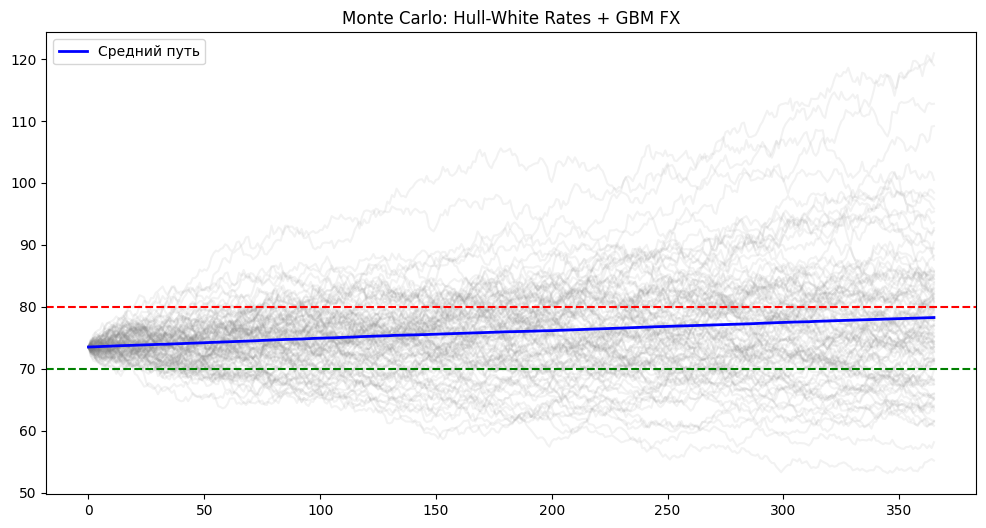

In [8]:
# График
plt.figure(figsize=(12, 6))
plt.plot(fx_path[:100].T, color='gray', alpha=0.1)
plt.plot(fx_path.mean(axis=0), color='blue', linewidth=2, label='Средний путь')
plt.axhline(U_barrier, color='red', linestyle='--')
plt.axhline(L_barrier, color='green', linestyle='--')
plt.title('Monte Carlo: Hull-White Rates + GBM FX')
plt.legend()
plt.show()